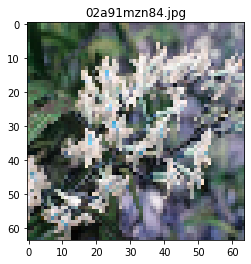

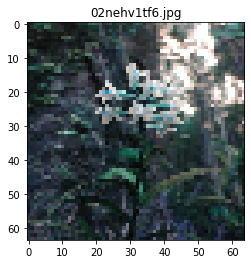

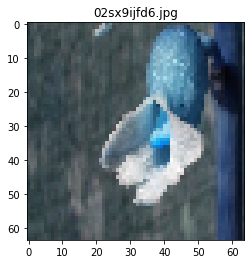

In [19]:
import  os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm
import sklearn.preprocessing

random_state = 42

def one_hot(x):
    a = np.array(x)
    label_binarizer = sklearn.preprocessing.LabelBinarizer()
    label_binarizer.fit(range(max(a)+1))
    b = label_binarizer.transform(a)
    return b

X_train_dir = './training'
files = os.listdir(X_train_dir)
files.sort()
for f in files[:3]:
    img = cv2.imread(X_train_dir+'/'+f)
    img = cv2.resize(img, dsize=(64,64), interpolation=cv2.INTER_CUBIC)
    plt.imshow(img)
    plt.title(f)
    plt.show()

# load y

In [20]:
label = pd.read_csv(X_train_dir+'/'+'label.csv')
y_one_hot = one_hot(label['category'].values.tolist())
y_one_hot

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

# load x

In [21]:
import requests
def load_x_from_img_dir(
    X_train_dir = './training',
    label = pd.read_csv(X_train_dir+'/'+'label.csv'),
    length=64,width=64):
    x = []
    for f in tqdm(label['filename'].values.tolist()):
        try:
            img = cv2.resize(
                cv2.imread(X_train_dir+'/'+f), 
                dsize=(length,width), 
                interpolation=cv2.INTER_CUBIC)
            img = np.moveaxis(img, -1, 0)
            x.append(img)
        except:
            pass
    return x
x_vector = load_x_from_img_dir(X_train_dir = './training')
x_vector = np.array(x_vector)
print(x_vector.shape)
x_train = x_vector
x_train = x_train.astype('float32') / 255.
print(x_train.shape)
print(x_train[0])

100%|██████████| 2190/2190 [00:07<00:00, 292.74it/s]


(2190, 3, 64, 64)
(2190, 3, 64, 64)
[[[0.5529412  0.12156863 0.25882354 ... 0.6745098  0.23529412 0.7019608 ]
  [0.15294118 0.5372549  0.57254905 ... 0.44313726 0.20784314 0.627451  ]
  [0.6039216  0.6039216  0.6117647  ... 0.6117647  0.6745098  0.22352941]
  ...
  [0.5254902  0.67058825 0.46666667 ... 0.67058825 0.6862745  0.6666667 ]
  [0.69803923 0.7882353  0.84313726 ... 0.654902   0.61960787 0.67058825]
  [0.34509805 0.44705883 0.44313726 ... 0.6313726  0.62352943 0.65882355]]

 [[0.5294118  0.10196079 0.24313726 ... 0.654902   0.21960784 0.6627451 ]
  [0.1254902  0.50980395 0.5803922  ... 0.44313726 0.19215687 0.59607846]
  [0.57254905 0.59607846 0.63529414 ... 0.6156863  0.6666667  0.20392157]
  ...
  [0.14117648 0.20784314 0.42352942 ... 0.7176471  0.73333335 0.7137255 ]
  [0.21568628 0.6117647  0.8117647  ... 0.7058824  0.68235296 0.7137255 ]
  [0.10196079 0.47843137 0.44705883 ... 0.5764706  0.5882353  0.6745098 ]]

 [[0.5372549  0.11372549 0.25882354 ... 0.6509804  0.2156862

# split data

In [22]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset
from torch import FloatTensor
X_train, X_test, y_train, y_test = train_test_split(
        x_train,
        y_one_hot, 
        test_size = 0.2, 
        random_state = random_state,
        )
train_loader = DataLoader(TensorDataset(
        FloatTensor(X_train),
        FloatTensor(y_train)),
        batch_size=128)
val_loader = DataLoader(TensorDataset(
        FloatTensor(X_test),
        FloatTensor(y_test)),
        batch_size=128)
for bx,by in train_loader:
    print(bx.shape,bx.device) # batch,channel,freq,time
    print(by.shape,by.device) # batch,n_class
    break

torch.Size([128, 3, 64, 64]) cpu
torch.Size([128, 219]) cpu


# build model

In [27]:
from torch import nn
import torch.hub
model = torch.hub.load('moskomule/senet.pytorch','se_resnet20',num_classes=y_one_hot.shape[1])
model.conv1 = nn.Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
for bx,by in train_loader:
    print(bx.shape,bx.device) # batch,channel,freq,time
    print(by.shape,by.device) # batch,n_class
    break
# forward test
model(bx).shape,by.shape

Using cache found in C:\Users\ricky/.cache\torch\hub\moskomule_senet.pytorch_master


torch.Size([128, 3, 64, 64]) cpu
torch.Size([128, 219]) cpu


(torch.Size([128, 219]), torch.Size([128, 219]))

# training model

In [28]:
from sklearn.metrics import accuracy_score

def train_step(model,train_iter,loss_fn,optimizer,device):
        model.train()
        total_loss = 0
        total_auc = 0
        for t,(x,y) in enumerate(train_iter):
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            total_auc += calculate_auc_score(model,x,y)
            loss = loss_fn(y_hat,y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()
        return total_loss/(t+1) ,total_auc/(t+1)

def valid_step(model,vaild_iter,loss_fn,optimizer,device):
    model.eval()
    total_loss = 0
    total_auc = 0
    for t,(x,y) in enumerate(vaild_iter):
        x,y = x.to(device),y.to(device)
        y_hat = model(x)
        total_auc += calculate_auc_score(model,x,y)
        loss = loss_fn(y_hat,y)
        total_loss += loss.item()
    return total_loss/(t+1) ,total_auc/(t+1)

def softmax2onehot(probs):
  probs = torch.FloatTensor(probs)
  max_idx = torch.argmax(probs, 1, keepdim=True)
  one_hot = torch.FloatTensor(probs.shape)
  one_hot.zero_()
  one_hot.scatter_(1, max_idx, 1)
  return one_hot.detach().cpu().numpy().astype(int)

# calculate roc_auc_score
def calculate_auc_score(model,x,y):
    y_hat = model(x).argmax(dim=1).detach().cpu().numpy()
    y = y.argmax(dim=1).detach().cpu().numpy()
    return accuracy_score(y,y_hat)
    #return 0 #roc_auc_score(y_hat,y)


# train_loop
def train(model,train_iter,vaild_iter,optimizer,loss_fn,max_epochs=300,log_interval=10,device=None):
        history = {
            'train_loss':[],
            'valid_loss':[],
            'train_auc':[],
            'valid_auc':[],
            }
        current_loss = np.inf
        best_model = None
        for i in tqdm(range(max_epochs)):
            # step
            train_loss,train_auc = train_step(model,train_iter,loss_fn,optimizer,device)
            valid_loss,valid_auc = valid_step(model,vaild_iter,loss_fn,optimizer,device)
            # record history
            history['train_loss'].append(train_loss)
            history['valid_loss'].append(valid_loss)
            history['train_auc'].append(train_auc)
            history['valid_auc'].append(valid_auc)
            # print info
            if i % log_interval == 0:
                print("epoch:{} train_loss:{:.4f} valid_loss:{:.4f} train_auc:{:.4f} valid_auc:{:.4f}".format(
                    i,history['train_loss'][-1],history['valid_loss'][-1],history['train_auc'][-1],history['valid_auc'][-1])
                    )
            # record the best model
            if history['valid_loss'][-1] <= current_loss:
                best_model = deepcopy(model.eval())
                current_loss = history['valid_loss'][-1]
                print('有進步')
            gc.collect()
        # copy best model
        model = deepcopy(best_model.eval())
        
        # plot
        plt.plot(history['train_loss'],label='train_loss')
        plt.plot(history['valid_loss'],label='valid_loss')
        plt.legend()
        plt.savefig('loss.jpg')
        plt.show()
        
        
        plt.plot(history['train_auc'],label='train_auc')
        plt.plot(history['valid_auc'],label='valid_auc')
        plt.legend()
        plt.savefig('auc.jpg')
        plt.show()
        
        
        return model

In [ ]:
from copy import deepcopy
device = 'cpu'
model = model.to(device)
#model = torch.nn.DataParallel(model, device_ids=[0, 1, 2 ,3])
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
loss_fn = nn.BCEWithLogitsLoss()
model = train(model,train_loader,val_loader,optimizer,loss_fn,max_epochs=100,log_interval=1,device=device)

In [ ]:
torch.save(model.state_dict(),'senet_randomseed_{random_state}.pt')

# model infernce test

In [ ]:
from sklearn.metrics import confusion_matrix,accuracy_score
def plot_confusion_matrix(model,data_iter,map_dict=map_dict):
    y_true = np.array([])
    y_pred = np.array([])
    for bx,by in tqdm(data_iter):
        bx = bx.to(device)
        by = by.to(device)
        y_hat = model(bx)
        try:
            if len(y_true) == 0:
                y_true = by.argmax(axis=1).detach().cpu().numpy()
                y_pred = y_hat.argmax(axis=1).detach().cpu().numpy()
            else:
                y_true = np.hstack((y_true,by.argmax(axis=1).detach().cpu().numpy()))
                y_pred = np.hstack((y_pred,y_hat.argmax(axis=1).detach().cpu().numpy()))
        except:
            pass
    cm = pd.DataFrame(confusion_matrix(y_pred,y_true))
    cm.columns = list(map_dict.values())
    acc = accuracy_score(y_pred,y_true)
    return cm,acc

In [ ]:
cm,acc = plot_confusion_matrix(model.to(device),train_loader)
print(acc)
cm

In [ ]:
cm,acc = plot_confusion_matrix(model.to(device),val_loader)
print(acc)
cm

# submit

In [ ]:
sample_submit = pd.DataFrame()
sample_submit['filename'] = label['filename'].values.tolist()
sample_submit['category'] =  None
batch = 100
for i in tqdm(range(0,X_test.shape[0]-batch+1,batch)):
    try:
        predict = model(X_test[i:i+batch].to(torch.float32).cuda()).detach().cpu().numpy()
        sample_submit.iloc[i:i+batch,1] = [np.argmax(i) for i in predict]
    except:
        predict = model(X_test[i:i+batch].to(torch.float32)).detach().cpu().numpy()
        sample_submit.iloc[i:i+batch,1] = [np.argmax(i) for i in predict]
sample_submit

# save

In [ ]:
sample_submit.to_csv('senet_randomseed_{random_state}.csv',index=False)
print('done')